# GAN Fashion MNIST

## Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

## Importing Libraries

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

import os

preparing an image for training by converting it into a tensor and normalizing its pixel values to have a mean of 0 and a standard deviation of 1 in the range [-1, 1]

In [ ]:

transform = Compose([
    ToTensor(),
    Normalize(mean=(0.5,),
     std=(0.5,))
])

## Loading FMNIST dataset

In [ ]:
fmnist = FashionMNIST(root='./data',
              train=True,
              download=True,
              transform=transform)

In [ ]:
test_dataset = FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [ ]:
img, label = fmnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

Function to reverse normalization

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


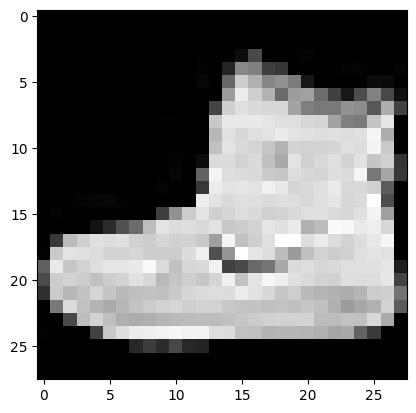

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

Dataloader for loading images in batches

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fmnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([4, 7, 2, 1, 0, 0, 7, 6, 2, 3, 0, 9, 4, 6, 8, 5, 0, 6, 1, 3, 5, 5, 9, 6,
        9, 0, 4, 4, 1, 9, 8, 6, 2, 7, 5, 0, 1, 1, 4, 2, 2, 7, 4, 2, 4, 8, 6, 0,
        4, 2, 7, 9, 3, 4, 3, 9, 2, 7, 9, 5, 3, 3, 5, 5, 7, 7, 5, 9, 5, 6, 1, 6,
        6, 6, 4, 7, 6, 5, 4, 7, 4, 9, 5, 6, 4, 8, 7, 2, 3, 6, 8, 8, 6, 4, 6, 8,
        6, 8, 6, 9])


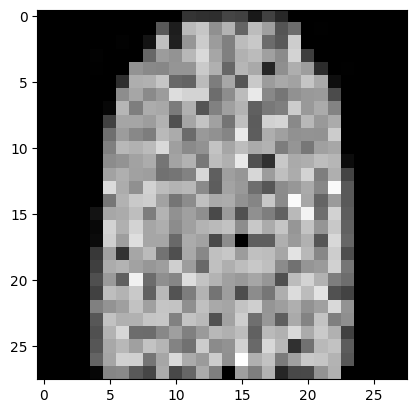

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

## Discriminator Network

In [ ]:
image_size = 784
hidden_size = 256

In [ ]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## Generator Network

Note: Like the demo have kept a simple 3 layer feed forward network for generator and discriminator

In [ ]:
latent_size = 64



*   The generator network is composed of linear layers and ReLU activations, with Tanh in the final layer to produce image-like outputs.

*  Tanh is used in the output layer because its range of [-1, 1] matches the normalized pixel range of image data.

*  ReLU is used in hidden layers for efficient gradient propagation and non-linear learning.

*  The network aims to generate realistic images by transforming random latent vectors into pixel values that mimic the color and structure of real images.



In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

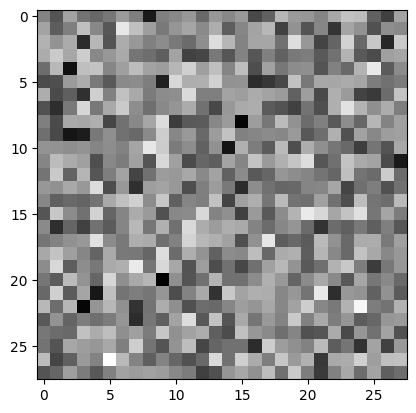

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray');

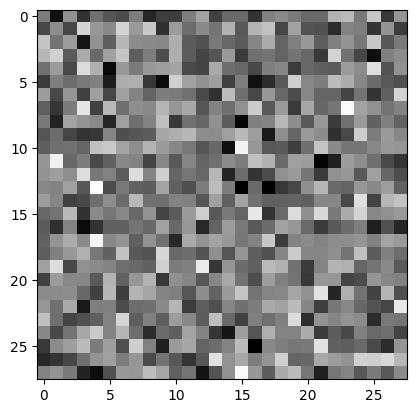

In [ ]:
plt.imshow(gen_imgs[1], cmap='gray');

In [ ]:
G.to(device);

## Discriminator Training

 Discriminator uses binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

1. Computing its ability to correctly classify real images (as "real").
2. Computing its ability to correctly classify fake images (as "fake").
3. Summing both losses and updating the discriminator's parameters to improve its classification performance. This is one half of the GAN training loop, with the other half involving training the generator to fool the discriminator into classifying fake images as real.

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

## Generator Training

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

This function trains the generator (G) in the GAN framework. The generator's goal is to produce fake images that can fool the discriminator (D).
The function:
1. Generating Fake Images
2. Labels for Loss Calculation
3. Calculating Generator Loss
4. Backpropagation and Optimization


In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [ ]:
# Set the directory path relative to the current working directory
sample_dir = 'Homework 5/samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [ ]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Homework 5',
 'mnist_gan.ipynb',
 'Untitled.ipynb']

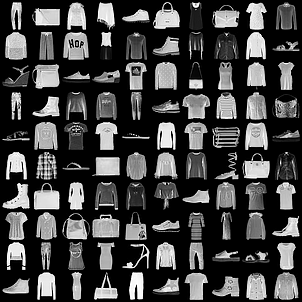

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


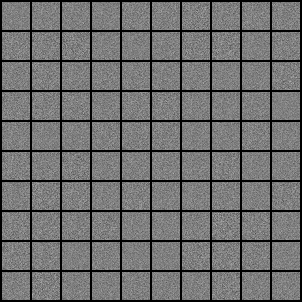

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

##  Step2. Train the GAN model to produce images in this new domain.

In [ ]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0910, g_loss: 3.8513, D(x): 0.98, D(G(z)): 0.06
Epoch [0/300], Step [400/600], d_loss: 0.1942, g_loss: 5.0293, D(x): 0.97, D(G(z)): 0.13
Epoch [0/300], Step [600/600], d_loss: 0.1189, g_loss: 4.6590, D(x): 0.94, D(G(z)): 0.05
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0371, g_loss: 4.4989, D(x): 0.99, D(G(z)): 0.03
Epoch [1/300], Step [400/600], d_loss: 0.0254, g_loss: 4.5350, D(x): 1.00, D(G(z)): 0.02
Epoch [1/300], Step [600/600], d_loss: 0.0529, g_loss: 4.5382, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0101, g_loss: 5.2159, D(x): 1.00, D(G(z)): 0.01
Epoch [2/300], Step [400/600], d_loss: 0.0192, g_loss: 6.2316, D(x): 0.99, D(G(z)): 0.01
Epoch [2/300], Step [600/600], d_loss: 0.0205, g_loss: 6.1031, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0623, g_loss: 5.4125, D(x): 0.98, D(G(z)): 0.03
Epoch [3/300], Step [400/6

## Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

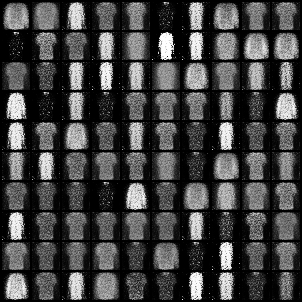

In [ ]:
Image('./Homework 5/samples/fake_images-0010.png')

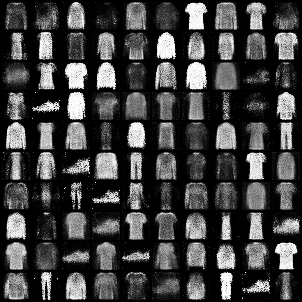

In [ ]:
Image('./Homework 5/samples/fake_images-0075.png')

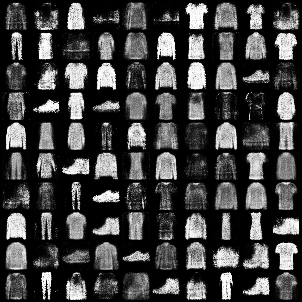

In [ ]:
Image('./Homework 5/samples/fake_images-0150.png')

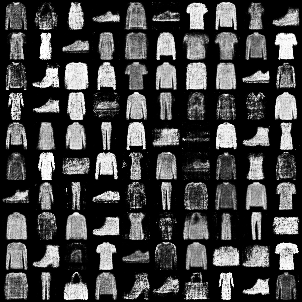

In [ ]:
Image('./Homework 5/samples/fake_images-0300.png')

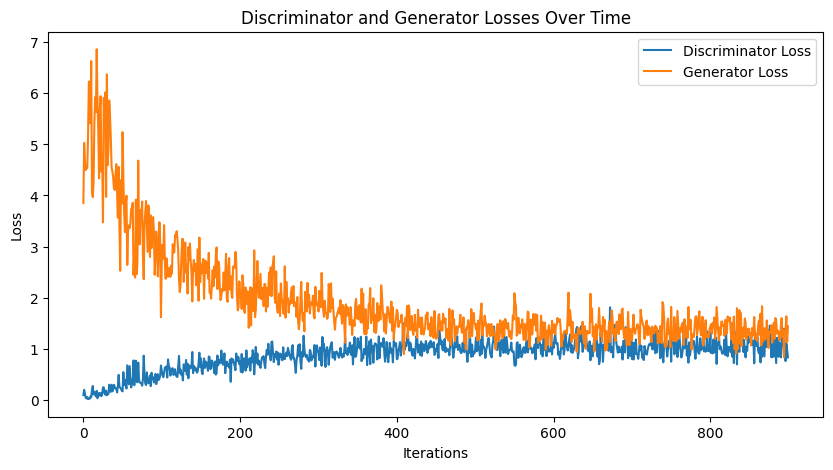

In [ ]:

# Plot discriminator loss
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Discriminator and Generator Losses Over Time')
plt.show()

the graph indicates successful GAN training where the generator improves over time, and both networks reach a balanced equilibrium, suggesting that the generated images are becoming more realistic while the discriminator remains moderately effective in distinguishing real from fake.

## Step4. Save the model weights in the folder to be used later.

In [ ]:
# Define the paths to save the model weights
generator_path = os.path.join(sample_dir, 'generator.pth')
discriminator_path = os.path.join(sample_dir, 'discriminator.pth')

# Save the generator model weights
torch.save(G.state_dict(), generator_path)
print(f"Generator weights saved at {generator_path}")

Generator weights saved at Homework 5/samples/generator.pth


In [ ]:
# Save the discriminator model weights
torch.save(D.state_dict(), discriminator_path)
print(f"Discriminator weights saved at {discriminator_path}")

Discriminator weights saved at Homework 5/samples/discriminator.pth


## Step5. Load the model using the saved weights.

In [ ]:
# Load the generator model weights
G.load_state_dict(torch.load(generator_path))
G.to(device)  # Move to the appropriate device
print(f"Generator weights loaded from {generator_path}")

Generator weights loaded from Homework 5/samples/generator.pth


In [ ]:
# Load the discriminator model weights
D.load_state_dict(torch.load(discriminator_path))
D.to(device)  # Move to the appropriate device
print(f"Discriminator weights loaded from {discriminator_path}")

Discriminator weights loaded from Homework 5/samples/discriminator.pth


## Step 6: Re-train the GAN model to see if you can improve.

In [ ]:
base_dir = 'Homework 5'

In [ ]:
# Define the new directory for saving re-trained images
retrained_image_dir = os.path.join(base_dir, 'retrained_images')

# Create the directory if it doesn't exist
if not os.path.exists(retrained_image_dir):
    os.makedirs(retrained_image_dir)

In [ ]:
# Modify the save_fake_images function to save in the new folder
def save_retrained_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'retrained_fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(retrained_image_dir, fake_fname), nrow=10)

In [ ]:
# Re-train loop with saving images in the new folder
num_retrain_epochs = 200  # Number of additional epochs for re-training

for epoch in range(num_retrain_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load and reshape images to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Log losses every 200 steps
        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_retrain_epochs}], Step [{i+1}/{total_step}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Save re-trained images in the retrained_images folder
    save_retrained_fake_images(epoch + 1 + num_epochs)

Epoch [1/200], Step [200/600], d_loss: 1.1496, g_loss: 1.2063, D(x): 0.62, D(G(z)): 0.35
Epoch [1/200], Step [400/600], d_loss: 1.2583, g_loss: 1.1701, D(x): 0.59, D(G(z)): 0.40
Epoch [1/200], Step [600/600], d_loss: 0.9426, g_loss: 1.3972, D(x): 0.71, D(G(z)): 0.37
Saving retrained_fake_images-0301.png
Epoch [2/200], Step [200/600], d_loss: 0.9551, g_loss: 1.3361, D(x): 0.62, D(G(z)): 0.28
Epoch [2/200], Step [400/600], d_loss: 1.2780, g_loss: 1.2941, D(x): 0.57, D(G(z)): 0.36
Epoch [2/200], Step [600/600], d_loss: 0.7563, g_loss: 1.7482, D(x): 0.72, D(G(z)): 0.28
Saving retrained_fake_images-0302.png
Epoch [3/200], Step [200/600], d_loss: 1.2435, g_loss: 1.2105, D(x): 0.60, D(G(z)): 0.39
Epoch [3/200], Step [400/600], d_loss: 1.4009, g_loss: 1.2406, D(x): 0.55, D(G(z)): 0.40
Epoch [3/200], Step [600/600], d_loss: 1.1108, g_loss: 1.3499, D(x): 0.55, D(G(z)): 0.28
Saving retrained_fake_images-0303.png
Epoch [4/200], Step [200/600], d_loss: 0.9389, g_loss: 1.3304, D(x): 0.70, D(G(z)): 0

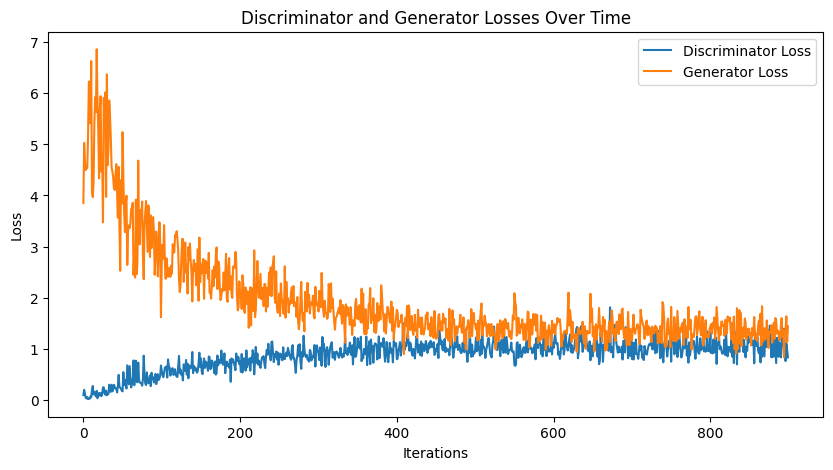

In [ ]:
### 1. Tracking and visualizing the losses in retraining the model


plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Discriminator and Generator Losses Over Time')
plt.show()

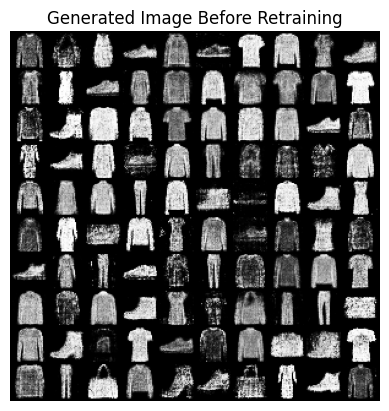

In [ ]:
# Load and display a generated image before retraining
before_img_path = os.path.join(sample_dir, 'fake_images-0300.png')
before_img = plt.imread(before_img_path)
plt.imshow(before_img, cmap='gray')
plt.title('Generated Image Before Retraining')
plt.axis('off')
plt.show()

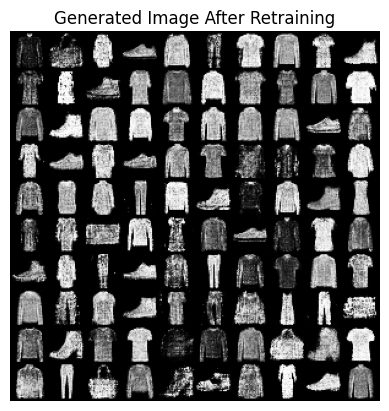

In [ ]:
# Load and display a generated image after retraining
after_img_path = os.path.join(retrained_image_dir, 'retrained_fake_images-0500.png')  # Adjust epoch index
after_img = plt.imread(after_img_path)
plt.imshow(after_img, cmap='gray')
plt.title('Generated Image After Retraining')
plt.axis('off')
plt.show()

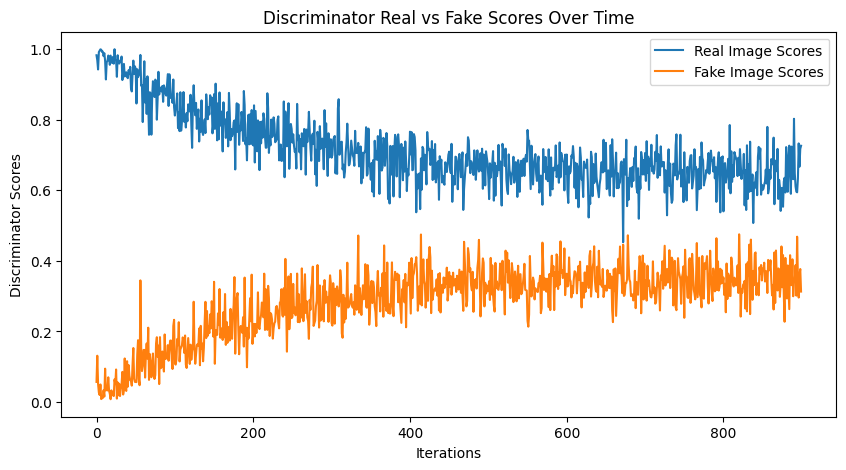

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(real_scores, label='Real Image Scores')
plt.plot(fake_scores, label='Fake Image Scores')
plt.xlabel('Iterations')
plt.ylabel('Discriminator Scores')
plt.legend()
plt.title('Discriminator Real vs Fake Scores Over Time')
plt.show()

## Step 7: Save the model weights without using checkpoints.

In [ ]:
# Define new paths to save the re-trained model weights
retrained_generator_path = os.path.join(retrained_image_dir, 'retrained_generator.pth')
retrained_discriminator_path = os.path.join(retrained_image_dir, 'retrained_discriminator.pth')

In [ ]:
# Save the re-trained generator model weights
torch.save(G.state_dict(), retrained_generator_path)
print(f"Re-trained generator weights saved at {retrained_generator_path}")

Re-trained generator weights saved at Homework 5/retrained_images/retrained_generator.pth


In [ ]:
# Save the re-trained discriminator model weights
torch.save(D.state_dict(), retrained_discriminator_path)
print(f"Re-trained discriminator weights saved at {retrained_discriminator_path}")

Re-trained discriminator weights saved at Homework 5/retrained_images/retrained_discriminator.pth


## Step 8: Load the model weights without using checkpoints.

In [ ]:
# Load the re-trained generator model weights
G.load_state_dict(torch.load(retrained_generator_path))
G.to(device)  # Move the model to the appropriate device
print(f"Re-trained generator weights loaded from {retrained_generator_path}")

Re-trained generator weights loaded from Homework 5/retrained_images/retrained_generator.pth


In [ ]:
# Load the re-trained discriminator model weights
D.load_state_dict(torch.load(retrained_discriminator_path))
D.to(device)  # Move the model to the appropriate device
print(f"Re-trained discriminator weights loaded from {retrained_discriminator_path}")

Re-trained discriminator weights loaded from Homework 5/retrained_images/retrained_discriminator.pth
